In [26]:
import os
from datetime import datetime

import torch
from torch import nn
from torchvision import datasets
import torchvision.transforms.v2 as transforms_v2
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_f1_score
)
from dl_utils import train_one_epoch, test, plot_predictions


In [27]:
import torchvision
print(torchvision.__version__)

0.21.0+cu124


In [ ]:
####################
# Dataset
####################
# Define a transform



train_trans = transforms_v2.Compose([
    transforms_v2.ToImage(),                                # Convert PIL → CHW tensor
    transforms_v2.ToDtype(torch.float32, scale=True),       # Convert to float32 and scale to [0, 1]
    transforms_v2.RandomHorizontalFlip(p=0.5),              # Flip image left-right
    transforms_v2.RandomApply([
        transforms_v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1)
    ], p=0.4),
    transforms_v2.RandomResizedCrop(size=(224, 224), antialias=True),
    transforms_v2.RandomApply([
        transforms_v2.GaussianBlur(kernel_size=3, sigma=(0.1, 0.8))
    ], p=0.2),
    transforms_v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

test_trans = transforms_v2.Compose([
    transforms_v2.ToImage(),  # Convert to tensor (C, H, W), only needed if you had a PIL image
    transforms_v2.Resize(256),  # Resize to have the smallest dimension of 72 while maintaining aspect ratio
    transforms_v2.CenterCrop(224),  # Center crop an image to be 64x64
    transforms_v2.ToDtype(torch.float32, scale=True),    # Converts the input to a type float32, and rescale from [0, 255] to [0, 1]
    transforms_v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize a tensor with mean and standard deviation.
])

In [36]:
# TODO: Define DataSet for train, valid, and test
data_dir = './data/THFOOD50-v1'
print(f"Data directory: {data_dir}")

Data directory: ./data/THFOOD50-v1


In [37]:
#datasetcleaner
# import os
# from PIL import Image

# root_dir = data_dir

# # delete bad images (set to True to auto-delete)
# delete_corrupted = True

# def is_image_file(filename):
#     return any(filename.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png'])

# bad_files = []

# for root, _, files in os.walk(root_dir):
#     for file in files:
#         if is_image_file(file):
#             file_path = os.path.join(root, file)
#             try:
#                 with Image.open(file_path) as img:
#                     img.load()       # force decode image
#                     img.convert('RGB')  # simulate what PyTorch will do

#             except Exception as e:
#                 print(f"Corrupted: {file_path} ({e})")
#                 bad_files.append(file_path)
#                 if delete_corrupted:
#                     os.remove(file_path)
#                     print(f"Deleted: {file_path}")

# print(f"\n Scan complete. Found {len(bad_files)} bad image(s).")


In [38]:
torch.manual_seed(42)

train_ds = datasets.ImageFolder(
    root=os.path.join(data_dir, "train"),
    transform= train_trans 
)

valid_ds = datasets.ImageFolder(
    root=os.path.join(data_dir, "val"),
    transform= test_trans
)
valid_ds, test_ds = random_split(valid_ds, [0.8, 0.2])

# Dataset sizes
print(f"Train set: {len(train_ds)} samples")
print(f"Valid set: {len(valid_ds)} samples")
print(f"Test set: {len(test_ds)} samples")


Train set: 14168 samples
Valid set: 1280 samples
Test set: 320 samples


In [39]:
####################
# Hyperparameters
####################
learning_rate = 1e-4    # TODO: Change this as you see fit
batch_size = 128         # TODO: Change this as you see fit
epochs = 20              # TODO: Change this as you see fit


In [40]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [42]:
####################
# Model
####################
# Detect computing device on your computer
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
    
# Import the model class from model.py
from torchvision.models import resnet34, ResNet34_Weights

# Create a model
weights = ResNet34_Weights.DEFAULT
model = resnet34(weights=weights)

num_ftrs = model.fc.in_features

# Add Dropout and an intermediate layer for better regularization
model.fc = nn.Sequential(
    nn.Dropout(p=0.3),                    # 🔁 Dropout before final layer
    nn.Linear(num_ftrs, len(train_ds.classes))  # Final classifier
)
model = model.to(device)

Using cuda device


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) (1): True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (2): True
ReLU(inplace=True) (3): True
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) (4): True
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3),

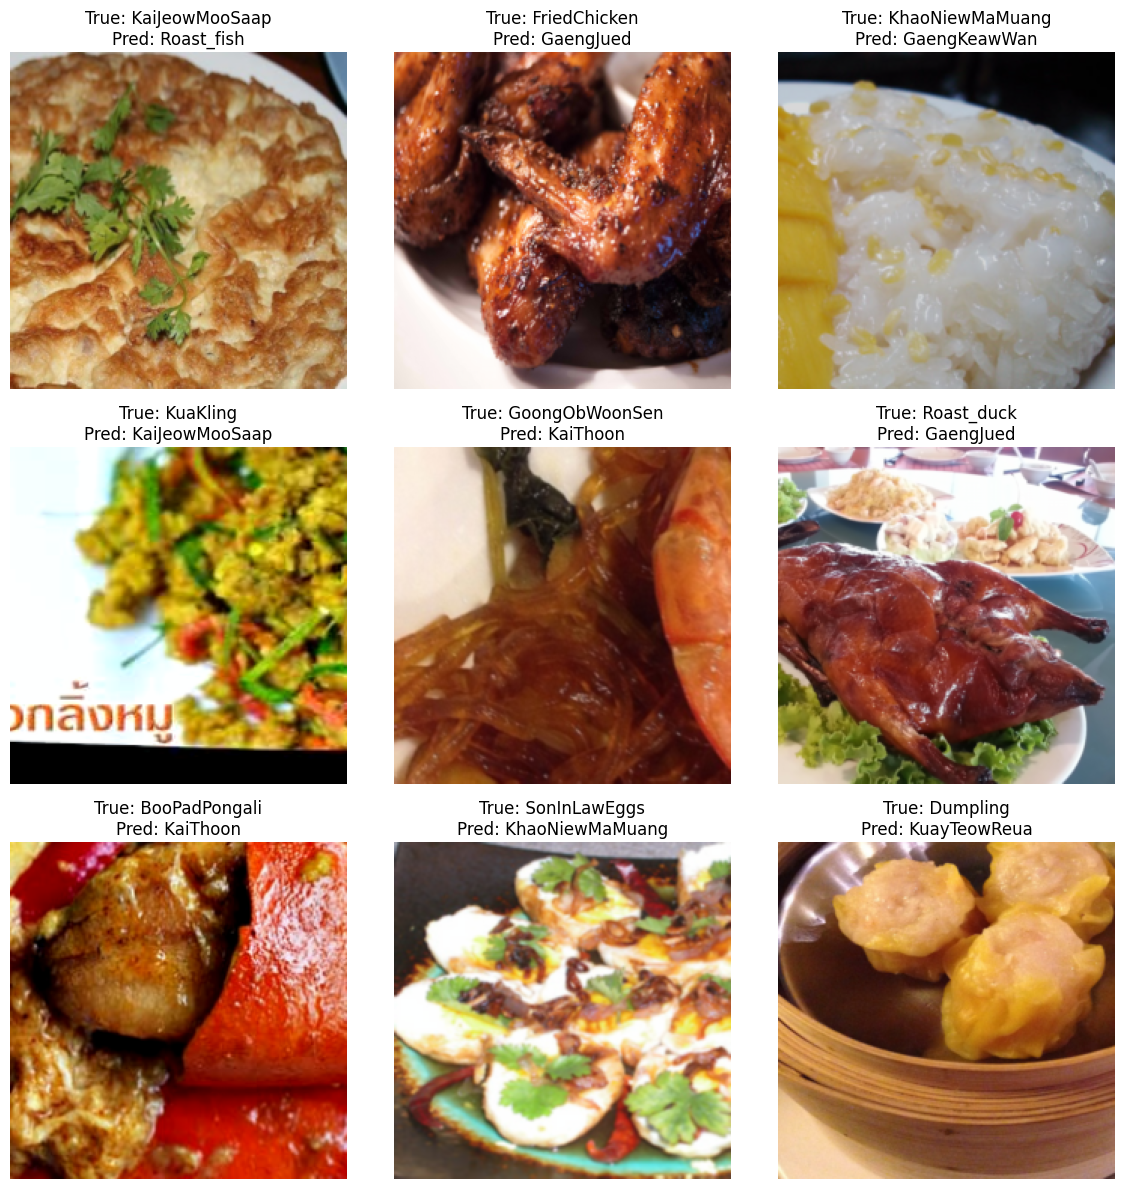

In [44]:
# TODO: Set `fine_tune_at` to specify how many layers to freeze
# Note: 
# - The lower the `fine_tune_at` value, the more layers are fine-tuned (or trained) from that layer onward until the last layer.
#     - `fine_tune_at=1` means you want to finetune all layers.
# - The number of layers varies depending on the model choice.
fine_tune_at = 1
ct = 0
for child in model.children():
    ct += 1
    if ct < fine_tune_at:
        for param in child.parameters():
            param.requires_grad = False
        print(f"{child} ({ct}): {False}")
    else:
        for param in child.parameters():
            param.requires_grad = True
        print(f"{child} ({ct}): {True}")

# Try to feed `batch_x` into the model to test the forward pass
batch_x, batch_y = next(iter(train_dl))
y_hat = model(batch_x.to(device))
y_pred = torch.argmax(y_hat, dim=1)  # this is optional
print(y_hat)
print(y_pred)  # this is optional

plot_predictions(batch_x, batch_y, y_pred, train_ds.classes)

In [45]:
####################
# Model Training
####################
# Setup tensorboard
writer = SummaryWriter(f'./runs/trainer_{model._get_name()}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [46]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

In [47]:
# Specify optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [48]:
# Training loop
best_vloss = 100000.
for epoch in range(epochs):
    print(f"Epoch {epoch+1} / {epochs}")
    train_one_epoch(train_dl, model, loss_fn, optimizer, epoch, device, writer, log_step_interval=1)
    train_loss, train_y_preds, train_y_trues = test(train_dl, model, loss_fn, device)
    val_loss, val_y_preds, val_y_trues = test(valid_dl, model, loss_fn, device)
    
    # Performance metrics
    train_perf = {
        'accuracy': multiclass_accuracy(train_y_preds, train_y_trues).item(),
        'f1': multiclass_f1_score(train_y_preds, train_y_trues).item(),
    }
    
    # Performance metrics
    val_perf = {
        'accuracy': multiclass_accuracy(val_y_preds, val_y_trues).item(),
        'f1': multiclass_f1_score(val_y_preds, val_y_trues).item(),
    }
    
    # Log model training performance
    writer.add_scalars('Train vs. Valid/loss', 
        {'train':train_loss, 'valid': val_loss}, 
        epoch)
    writer.add_scalars(
        'Performance/acc', 
        {'train':train_perf['accuracy'], 'valid': val_perf['accuracy']},
        epoch)
    writer.add_scalars(
        'Performance/f1', 
        {'train':train_perf['f1'], 'valid': val_perf['f1']},
        epoch)

    # Track best performance, and save the model's state
    if val_loss < best_vloss:
        best_vloss = val_loss
        torch.save(model.state_dict(), 'model_best_resnet34new.pth')
        print('Saved best model to model_best_vloss.pth')
print("Done!")

Epoch 1 / 20
loss: 4.194919  [  128/14168] | GPU: Allocated = 4.434 GB, Reserved = 10.459 GB
loss: 4.112926  [  256/14168] | GPU: Allocated = 4.434 GB, Reserved = 10.459 GB
loss: 4.036221  [  384/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 3.938319  [  512/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 3.838295  [  640/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 3.809856  [  768/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 3.714123  [  896/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 3.666312  [ 1024/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 3.588438  [ 1152/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 3.501168  [ 1280/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 3.470490  [ 1408/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 3.437251  [ 1536/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 3.418411  [ 1664/1416

loss: 1.409761  [13312/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 1.159325  [13440/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 1.332918  [13568/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 1.151965  [13696/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 1.327710  [13824/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 1.484782  [13952/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 1.315049  [14080/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 1.120571  [ 9768/14168] | GPU: Allocated = 4.412 GB, Reserved = 10.459 GB
Saved best model to model_best_vloss.pth
Epoch 2 / 20
loss: 1.177546  [  128/14168] | GPU: Allocated = 4.434 GB, Reserved = 10.459 GB
loss: 1.024412  [  256/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 1.015153  [  384/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 1.132147  [  512/14168] | GPU: Allocated = 4.433 GB, Reserve

loss: 0.978553  [12160/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.719927  [12288/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.799849  [12416/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 1.032104  [12544/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.886956  [12672/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.834926  [12800/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.856624  [12928/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 1.002864  [13056/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 1.020213  [13184/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.870117  [13312/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.802775  [13440/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.809890  [13568/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.841884  [13696/14168] | GPU: All

loss: 0.728188  [11008/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.781999  [11136/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.551311  [11264/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.761930  [11392/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.783906  [11520/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.702476  [11648/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.741085  [11776/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.642101  [11904/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.709033  [12032/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.688839  [12160/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.758301  [12288/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.561191  [12416/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.769956  [12544/14168] | GPU: All

loss: 0.625589  [ 9856/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.671305  [ 9984/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.564500  [10112/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.733578  [10240/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.619412  [10368/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.539093  [10496/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.499753  [10624/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.476019  [10752/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.418672  [10880/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.610251  [11008/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.626788  [11136/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.685324  [11264/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.694362  [11392/14168] | GPU: All

loss: 0.480816  [ 8704/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.530896  [ 8832/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.499506  [ 8960/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.431774  [ 9088/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.652364  [ 9216/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.508649  [ 9344/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.590690  [ 9472/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.404201  [ 9600/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.625993  [ 9728/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.514067  [ 9856/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.656815  [ 9984/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.622375  [10112/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.571517  [10240/14168] | GPU: All

loss: 0.600835  [ 7552/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.455467  [ 7680/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.642464  [ 7808/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.351235  [ 7936/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.463536  [ 8064/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.395127  [ 8192/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.602985  [ 8320/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.534396  [ 8448/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.491869  [ 8576/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.550230  [ 8704/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.478144  [ 8832/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.527999  [ 8960/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.659707  [ 9088/14168] | GPU: All

loss: 0.337191  [ 6400/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.414742  [ 6528/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.373384  [ 6656/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.292017  [ 6784/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.476404  [ 6912/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.368894  [ 7040/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.598356  [ 7168/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.466134  [ 7296/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.411816  [ 7424/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.451566  [ 7552/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.425759  [ 7680/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.712284  [ 7808/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.406535  [ 7936/14168] | GPU: All

loss: 0.450696  [ 5376/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.378021  [ 5504/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.282866  [ 5632/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.396854  [ 5760/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.448622  [ 5888/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.287044  [ 6016/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.507457  [ 6144/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.462974  [ 6272/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.381974  [ 6400/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.353644  [ 6528/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.334156  [ 6656/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.393142  [ 6784/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.506735  [ 6912/14168] | GPU: All

loss: 0.427052  [ 4352/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.553235  [ 4480/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.461539  [ 4608/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.472702  [ 4736/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.309107  [ 4864/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.353379  [ 4992/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.454179  [ 5120/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.344194  [ 5248/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.515126  [ 5376/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.365013  [ 5504/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.436496  [ 5632/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.369003  [ 5760/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.547664  [ 5888/14168] | GPU: All

loss: 0.421534  [ 3200/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.256523  [ 3328/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.336524  [ 3456/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.430846  [ 3584/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.334578  [ 3712/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.340204  [ 3840/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.320149  [ 3968/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.172551  [ 4096/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.222448  [ 4224/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.224166  [ 4352/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.378778  [ 4480/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.413347  [ 4608/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.447761  [ 4736/14168] | GPU: All

loss: 0.302556  [ 2176/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.404287  [ 2304/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.405575  [ 2432/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.294499  [ 2560/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.323415  [ 2688/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.393436  [ 2816/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.264895  [ 2944/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.370979  [ 3072/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.302497  [ 3200/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.302708  [ 3328/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.323398  [ 3456/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.448896  [ 3584/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.286801  [ 3712/14168] | GPU: All

loss: 0.207299  [ 1024/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.387058  [ 1152/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.310176  [ 1280/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.347032  [ 1408/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.408162  [ 1536/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.274053  [ 1664/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.422464  [ 1792/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.307476  [ 1920/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.306587  [ 2048/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.319287  [ 2176/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.309858  [ 2304/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.303547  [ 2432/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.398277  [ 2560/14168] | GPU: All

loss: 0.242655  [ 9768/14168] | GPU: Allocated = 4.412 GB, Reserved = 10.459 GB
Epoch 13 / 20
loss: 0.245703  [  128/14168] | GPU: Allocated = 4.434 GB, Reserved = 10.459 GB
loss: 0.223312  [  256/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.349136  [  384/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.373195  [  512/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.348687  [  640/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.318376  [  768/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.330946  [  896/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.228117  [ 1024/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.268210  [ 1152/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.255513  [ 1280/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.377570  [ 1408/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.300985  [ 1536/141

loss: 0.290550  [13184/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.268994  [13312/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.378465  [13440/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.336800  [13568/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.318555  [13696/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.332458  [13824/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.210870  [13952/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.298591  [14080/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.241153  [ 9768/14168] | GPU: Allocated = 4.412 GB, Reserved = 10.459 GB
Saved best model to model_best_vloss.pth
Epoch 14 / 20
loss: 0.213617  [  128/14168] | GPU: Allocated = 4.434 GB, Reserved = 10.459 GB
loss: 0.339158  [  256/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.241168  [  384/14168] | GPU: Allocated = 4.433 GB, Reserv

loss: 0.241223  [12032/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.415538  [12160/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.246721  [12288/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.330564  [12416/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.236858  [12544/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.327117  [12672/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.311998  [12800/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.259900  [12928/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.277815  [13056/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.231162  [13184/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.386853  [13312/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.417555  [13440/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.169657  [13568/14168] | GPU: All

loss: 0.299082  [10880/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.181767  [11008/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.390982  [11136/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.340106  [11264/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.204552  [11392/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.186486  [11520/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.387909  [11648/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.267853  [11776/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.259534  [11904/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.191108  [12032/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.294090  [12160/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.366562  [12288/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.221638  [12416/14168] | GPU: All

loss: 0.261948  [ 9856/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.299794  [ 9984/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.146904  [10112/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.301305  [10240/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.266515  [10368/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.327558  [10496/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.281633  [10624/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.215296  [10752/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.249999  [10880/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.329285  [11008/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.373602  [11136/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.182369  [11264/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.297203  [11392/14168] | GPU: All

loss: 0.300608  [ 8832/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.102378  [ 8960/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.221349  [ 9088/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.301973  [ 9216/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.355851  [ 9344/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.258887  [ 9472/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.269456  [ 9600/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.262521  [ 9728/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.188208  [ 9856/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.279002  [ 9984/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.280628  [10112/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.177745  [10240/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.437176  [10368/14168] | GPU: All

loss: 0.297489  [ 7808/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.173127  [ 7936/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.220525  [ 8064/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.230857  [ 8192/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.331975  [ 8320/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.285235  [ 8448/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.359201  [ 8576/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.334138  [ 8704/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.231931  [ 8832/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.206926  [ 8960/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.301860  [ 9088/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.452934  [ 9216/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.251308  [ 9344/14168] | GPU: All

loss: 0.161090  [ 6784/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.232122  [ 6912/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.276904  [ 7040/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.138825  [ 7168/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.263179  [ 7296/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.191616  [ 7424/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.216992  [ 7552/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.186380  [ 7680/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.262589  [ 7808/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.204278  [ 7936/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.220980  [ 8064/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.141229  [ 8192/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.228619  [ 8320/14168] | GPU: All

loss: 0.256138  [ 5760/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.377858  [ 5888/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.218596  [ 6016/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.162857  [ 6144/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.136651  [ 6272/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.271769  [ 6400/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.239013  [ 6528/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.290996  [ 6656/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.269480  [ 6784/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.322240  [ 6912/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.181360  [ 7040/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.215471  [ 7168/14168] | GPU: Allocated = 4.433 GB, Reserved = 10.459 GB
loss: 0.240585  [ 7296/14168] | GPU: All

In [50]:
###########################
# Evaluate on the Test Set
###########################
# TODO: Load the best model
model_best = model
model_best.load_state_dict(torch.load('model_best_resnet34new.pth'))
model_best.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
# TODO: Use the best model on the training set
train_loss, train_y_preds, train_y_trues = test(train_dl, model_best, loss_fn,device)

# Performance metrics on the training set
train_perf = {
    'accuracy': multiclass_accuracy(train_y_preds, train_y_trues).item(),
    'f1': multiclass_f1_score(train_y_preds, train_y_trues).item(),
}

# TODO: Use the best model on the test set
test_loss, test_y_preds, test_y_trues = test(test_dl, model_best, loss_fn,device)


# Performance metrics
test_perf = {
    'accuracy': multiclass_accuracy(test_y_preds, test_y_trues).item(),
    'f1': multiclass_f1_score(test_y_preds, test_y_trues).item(),
}

print(f"Train: loss={train_loss:>8f}, acc={(100*train_perf['accuracy']):>0.1f}%, f1={(100*train_perf['f1']):>0.1f}%")
print(f"Test: loss={test_loss:>8f}, acc={(100*test_perf['accuracy']):>0.1f}%, f1={(100*test_perf['f1']):>0.1f}%")


Train: loss=0.241549, acc=93.2%, f1=93.2%
Test: loss=0.360473, acc=90.3%, f1=90.3%


tensor([[-2.4513,  2.0617, -1.8727,  ..., -0.7905, -1.1325, -2.9002],
        [ 4.3390, -1.0353, -2.8517,  ..., -1.7276, -2.7036, -0.7387],
        [-2.9426,  0.6373, -1.6246,  ..., -2.3941, -3.0036, -1.6669],
        ...,
        [-2.5947, -0.7221, -1.2051,  ..., -3.4300, -2.6388, -2.6427],
        [ 3.1673, -1.9416, -0.7450,  ..., -2.0757, -0.9357, -1.7911],
        [-2.9313, -0.2691, -1.3749,  ...,  0.3814, -1.3347, -1.8910]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([21,  0, 15,  0, 44,  4, 28, 31, 45,  5,  9, 46,  9,  1, 13, 35, 42, 30,
        10, 48, 24, 28, 11,  9, 28, 42, 41, 15, 11, 35,  7, 28, 12,  8, 29, 31,
        31, 10, 38, 33, 32,  3, 13, 26, 31, 16,  4, 49,  3, 33, 31, 41, 11,  0,
        23, 18, 11, 28, 16, 30,  2, 28, 48, 28,  0, 30, 25, 38, 34, 46,  5, 25,
        14,  2,  8, 44, 10, 37, 27, 47, 33, 22, 17, 32, 41,  8, 19, 23,  2,  3,
        33, 20,  3,  7,  3, 31, 25, 18,  6, 48, 41,  0, 48,  1, 42, 13, 14, 10,
        16,  8, 29, 10, 31, 17, 40, 

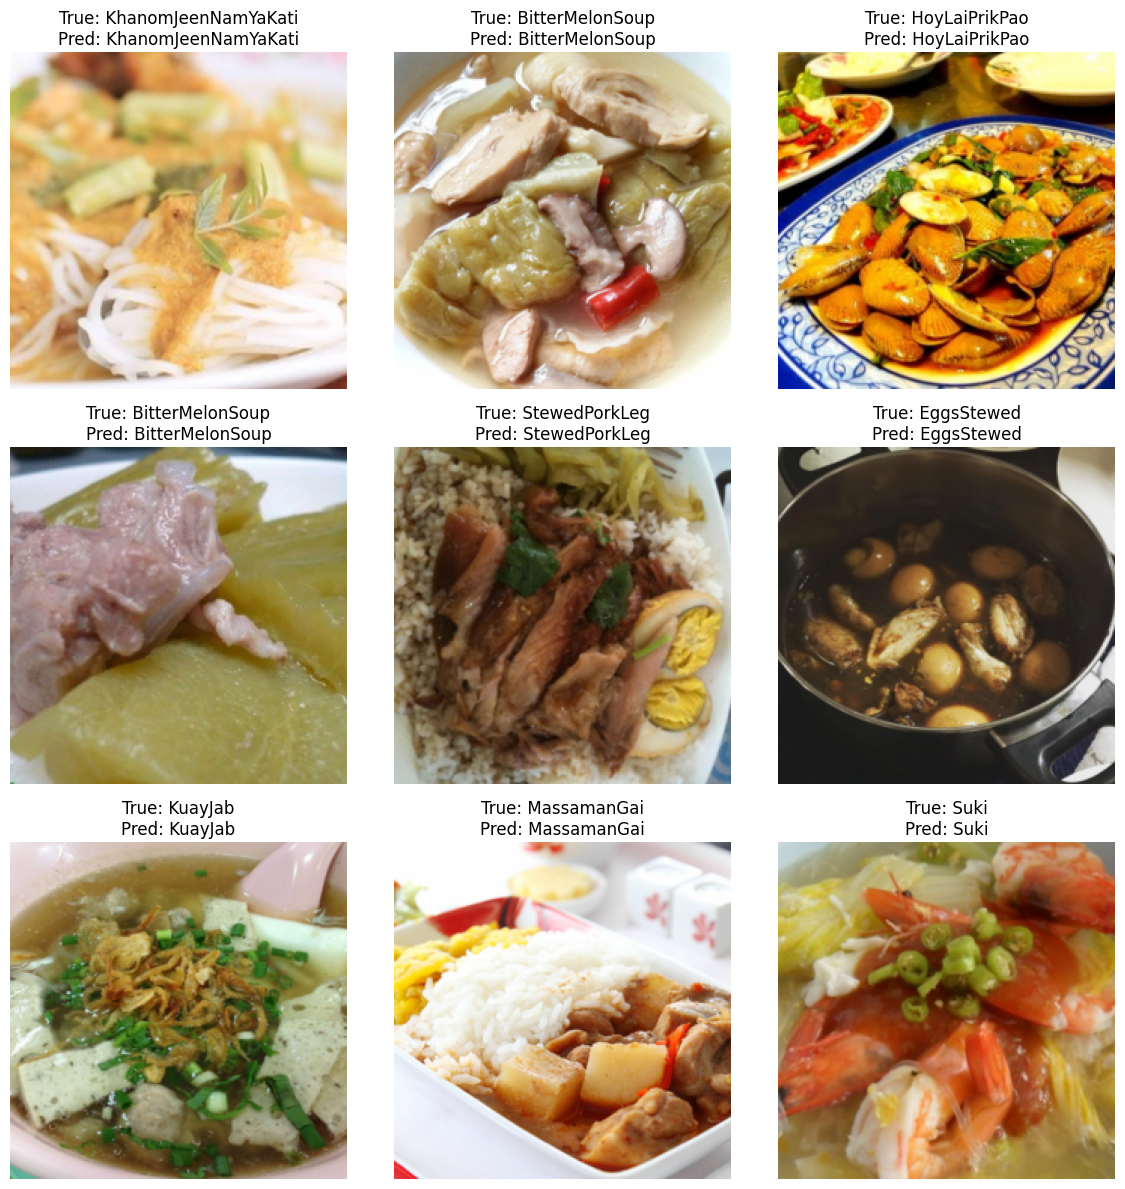

In [54]:
batch_x, batch_y = next(iter(valid_dl))
y_hat = model(batch_x.to(device))
y_pred = torch.argmax(y_hat, dim=1)  # this is optional
print(y_hat)
print(y_pred)  # this is optional

plot_predictions(batch_x, batch_y, y_pred, train_ds.classes)